## Initialization

### Packages

In [2]:
# Import packages
import numpy as np
import ROOT as root
import matplotlib
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from matplotlib.backends.backend_pdf import PdfPages

### Functions

In [16]:
def create_yield_hist(edges_minust):
    yield_hist = []
    for i in range(len(edges_minust)):
        yield_hist_energy = []
        for j in range(len(edges_minust[i])-1):
            yield_hist_minust = root.TH1F("", "", hist_bins, hist_low, hist_high)
            yield_hist_energy.append(yield_hist_minust)
        yield_hist.append(yield_hist_energy)
    return yield_hist

def create_zero_list(edges_minust):
    zero_list = []
    for i in range(len(edges_minust)):
        zero_list_energy = []
        for j in range(len(edges_minust[i])-1):
            zero_list_energy.append(0)
        zero_list.append(zero_list_energy)
    return zero_list

def hist_points_1D(hist):
    Nbins = hist.GetNbinsX()
    x, y, x_err, y_err = np.empty(Nbins), np.empty(Nbins), np.empty(Nbins), np.empty(Nbins)
    for i in range(Nbins):
        x[i], y[i], x_err[i], y_err[i]  = hist.GetBinCenter(i+1), hist.GetBinContent(i+1), hist.GetBinWidth(i+1), hist.GetBinError(i+1)
    return [x, y, x_err, y_err]

def hist_points_2D(hist):
    NbinsX, NbinsY = hist.GetNbinsX(), hist.GetNbinsY()
    x_edges, y_edges = np.empty(NbinsX+1), np.empty(NbinsY+1)
    z, z_err = np.empty([NbinsX, NbinsY]), np.empty([NbinsX, NbinsY])
    
    for i in range(NbinsX):
        x_edges[i] = hist.GetXaxis().GetBinLowEdge(i+1)
    x_edges[-1] = hist.GetXaxis().GetBinUpEdge(NbinsX)
    for j in range(NbinsY):
        y_edges[j] = hist.GetYaxis().GetBinLowEdge(j+1)
    y_edges[-1] = hist.GetYaxis().GetBinUpEdge(NbinsY)
    
    for i in range(NbinsX):
        for j in range(NbinsY):
            z[i,j] = hist.GetBinContent(i+1, j+1)
            z_err[i,j] = hist.GetBinError(i+1, j+1)
            
    return [x_edges, y_edges, z, z_err]

def double_gaussian(x, c1, sigma1, c2, sigma2, mu):
    return c1/sigma1/np.sqrt(2*np.pi)*np.exp(-(x-mu)**2/(2*sigma1**2)) + c2/sigma2/np.sqrt(2*np.pi)*np.exp(-(x-mu)**2/(2*sigma2**2))

def double_gaussian_plus_linear(x, c1, sigma1, c2, sigma2, mu, a, b):
    return c1/sigma1/np.sqrt(2*np.pi)*np.exp(-(x-mu)**2/(2*sigma1**2)) + c2/sigma2/np.sqrt(2*np.pi)*np.exp(-(x-mu)**2/(2*sigma2**2)) + a*x + b

def gaussian(x, c, sigma, mu):
    return c/sigma/np.sqrt(2*np.pi)*np.exp(-(x-mu)**2/(2*sigma**2))

def gaussian_plus_linear(x, c, sigma, mu, a, b):
    return c/sigma/np.sqrt(2*np.pi)*np.exp(-(x-mu)**2/(2*sigma**2)) + a*x + b

### Constants

In [4]:
edges_tagger = [266, 248, 228, 177, 126, 64, 0,]

edges_energy = []
tagger_bins = np.loadtxt("/work/halld2/home/boyu/src_analysis/flux/output/deuterium/flux_corr_90207.txt")
for tagger in edges_tagger:
    if tagger != 0:
        edges_energy.append(tagger_bins[tagger-1][2])
    else:
        edges_energy.append(tagger_bins[tagger][4])
        
edges_minust = [
                [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.5, 1.8, 8.0, 10.0, 11.5],
                [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.5, 1.8, 2.5, 8.0, 10.0, 12.0, 13.5],
                [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.6, 2.0, 6.0, 10.0, 11.0, 12.0, 13.0, 13.5],
                [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.5, 2.0, 2.5, 10.0, 12.0, 13.5, 14.5],
                [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.5, 2.0, 2.5, 6.5, 12.0, 13.5, 14.5, 15.5, 16.5],
                [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0, 1.5, 2.2, 3.0, 4.5, 12.5, 15.0, 16.5],
               ]

hist_low = -2.0
hist_high = 4.0
hist_bins = 60
hist_norm = (hist_high - hist_low)/hist_bins

## Yield extraction

### Data

In [31]:
file_data   = root.TFile("/work/halld2/home/boyu/src_analysis/selection/output/flattree_piminus_p_2H_data.root")
tree_data   = file_data.Get("piminus_p_2H_recon")
yield_hist_data = create_yield_hist(edges_minust)
hist_pt = root.TH2F("pt", "pt", 60, 5, 11, 20, 0, 2)
hist_ptp = root.TH2F("ptp", "ptp", 10, 0, 2, 20, 0, 2)

for i in range(tree_data.GetEntries()):
    tree_data.GetEntry(i)
    BeamP4_Measured    = tree_data.BeamP4_Measured
    PiMinusP4_Measured = tree_data.PiMinusP4_Measured
    ProtonP4_Measured  = tree_data.ProtonP4_Measured
    MissingP4_Measured = tree_data.MissingP4_Measured
    AccidWeight      = tree_data.HistAccidWeightFactor
    
    MinusT_Measured = -(BeamP4_Measured - PiMinusP4_Measured).Mag2()
    
    hist_pt.Fill(BeamP4_Measured.E(), ProtonP4_Measured.Pt(), AccidWeight)
    hist_ptp.Fill(ProtonP4_Measured.P(), ProtonP4_Measured.Pt(), AccidWeight)
    
    for j in range(len(edges_energy)-1):
        if BeamP4_Measured.E() < edges_energy[j+1]:
            for k in range(len(edges_minust[j])-1):
                if MinusT_Measured < edges_minust[j][k+1]:
                    yield_hist_data[j][k].Fill(MissingP4_Measured.M2(), AccidWeight)
                    break
            break

yield_data = []
yield_data_err = []

with PdfPages('output/fit_piminus_p_2H_data.pdf') as pdf:

    for i in range(len(edges_energy)-1):
        
        yield_data_energy = []
        yield_data_err_energy = []
        
        for j in range(len(edges_minust[i])-1):
            
            points = hist_points_1D(yield_hist_data[i][j])

            popt, pcov = curve_fit(gaussian, points[0][points[1].nonzero()], points[1][points[1].nonzero()], sigma=points[3][points[1].nonzero()], absolute_sigma=True, p0=[points[1].sum()/100, 0.4, 0.95], bounds=[[0, 0.1, 0.5], [points[1].sum(), 1, 1.3]])
            perr = np.sqrt(np.diag(pcov))
            
            yield_data_energy.append(popt[0]/hist_norm)
            yield_data_err_energy.append(perr[0]/hist_norm)

            fig, ax = plt.subplots(figsize=(10, 7))
            plt.errorbar(points[0], points[1], xerr=points[2], yerr=points[3], fmt='o')
            plt.plot(np.linspace(-2, 4, 1000), gaussian(np.linspace(-2, 4, 1000), popt[0], popt[1], popt[2]))
            plt.xlabel('$M^2_{miss} [GeV^2]$')
            plt.ylabel('Counts/0.02 $GeV^2$')
            plt.text(1, 1, \
                     '${0:.3f} \, GeV \, < \, E_\\gamma \, < \, {1:.3f} \, GeV$ \n \
                      ${2:.1f} \, GeV^2 \, < \, -t \, < \, {3:.1f} \, GeV^2$ \n \
                      $N_{{\\pi^-}} \, = \, {4:.3f} \, \pm \, {5:.3f}$ \n \
                      $\sigma \, = \, {6:.3f} \, \pm \, {7:.3f} \, GeV^2$ \n \
                      $M^2_p \, = \, {8:.3f} \, \pm \, {9:.3f} \, GeV^2$'\
                     .format(edges_energy[i], edges_energy[i+1], edges_minust[i][j], edges_minust[i][j+1], popt[0]/hist_norm, perr[0]/hist_norm, popt[1], perr[1], popt[2], perr[2]), \
                     fontsize=15, ha='right', va='top', transform=ax.transAxes\
                    )

            pdf.savefig()
            plt.close()
        
        yield_data.append(yield_data_energy)
        yield_data_err.append(yield_data_err_energy)

Text(0, 0.5, '$E_{\\gamma}$ [GeV]')

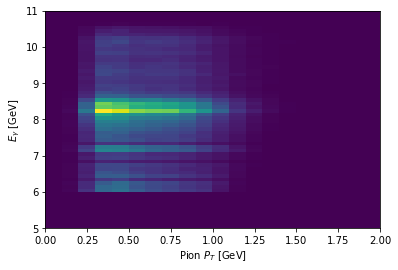

In [26]:
pt_points = hist_points_2D(hist_pt)
plt.pcolormesh(pt_points[1],pt_points[0],pt_points[2])
plt.xlabel("Pion $P_T$ [GeV]")
plt.ylabel("$E_{\gamma}$ [GeV]")

Text(0, 0.5, 'Pion $P$ [GeV]')

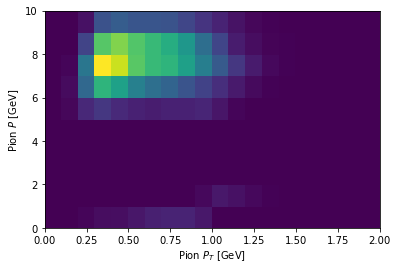

In [27]:
ptp_points = hist_points_2D(hist_ptp)
plt.pcolormesh(ptp_points[1],ptp_points[0],ptp_points[2])
plt.xlabel("Pion $P_T$ [GeV]")
plt.ylabel("Pion $P$ [GeV]")

Text(0, 0.5, 'Proton $P$ [GeV]')

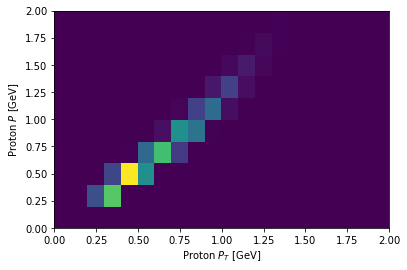

In [32]:
ptp_points = hist_points_2D(hist_ptp)
plt.pcolormesh(ptp_points[1],ptp_points[0],ptp_points[2])
plt.xlabel("Proton $P_T$ [GeV]")
plt.ylabel("Proton $P$ [GeV]")

### Sim

In [8]:
file_sim    = root.TFile("/work/halld2/home/boyu/src_analysis/selection/output/flattree_piminus_p_2H_sim.root")
tree_sim    = file_sim.Get("piminus_p_2H_recon")
yield_hist_sim = create_yield_hist(edges_minust)

for i in range(tree_sim.GetEntries()):
    tree_sim.GetEntry(i)
    BeamP4_Measured    = tree_sim.BeamP4_Measured
    PiMinusP4_Measured = tree_sim.PiMinusP4_Measured
    ProtonP4_Measured  = tree_sim.ProtonP4_Measured
    MissingP4_Measured = tree_sim.MissingP4_Measured
    AccidWeight      = tree_sim.HistAccidWeightFactor
    L1TriggerBits    = tree_sim.L1TriggerBits
    
    MinusT_Measured = -(BeamP4_Measured - PiMinusP4_Measured).Mag2()
    
    if L1TriggerBits == 0:
        continue
    
    for j in range(len(edges_energy)-1):
        if BeamP4_Measured.E() < edges_energy[j+1]:
            for k in range(len(edges_minust[j])-1):
                if MinusT_Measured < edges_minust[j][k+1]:
                    yield_hist_sim[j][k].Fill(MissingP4_Measured.M2(), AccidWeight)
                    break
            break

yield_sim = []
yield_sim_err = []

from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('output/fit_piminus_p_2H_sim.pdf') as pdf:

    for i in range(len(edges_energy)-1):
        
        yield_sim_energy = []
        yield_sim_err_energy = []
        
        for j in range(len(edges_minust[i])-1):
            
            points = hist_points_1D(yield_hist_sim[i][j])

            popt, pcov = curve_fit(gaussian, points[0][points[1].nonzero()], points[1][points[1].nonzero()], sigma=points[3][points[1].nonzero()], absolute_sigma=True, p0=[points[1].sum()/100, 0.4, 0.95], bounds=[[0, 0.1, 0.5], [points[1].sum(), 1, 1.3]])
            perr = np.sqrt(np.diag(pcov))
            
            yield_sim_energy.append(popt[0]/hist_norm)
            yield_sim_err_energy.append(perr[0]/hist_norm)

            fig, ax = plt.subplots(figsize=(10, 7))
            plt.errorbar(points[0], points[1], xerr=points[2], yerr=points[3], fmt='o')
            plt.plot(np.linspace(-2, 4, 1000), gaussian(np.linspace(-2, 4, 1000), popt[0], popt[1], popt[2]))
            plt.xlabel('$M^2_{miss} [GeV^2]$')
            plt.ylabel('Counts/0.02 $GeV^2$')
            plt.text(1, 1, \
                     '${0:.3f} \, GeV \, < \, E_\\gamma \, < \, {1:.3f} \, GeV$ \n \
                      ${2:.1f} \, GeV^2 \, < \, -t \, < \, {3:.1f} \, GeV^2$ \n \
                      $N_{{\\pi^-}} \, = \, {4:.3f} \, \pm \, {5:.3f}$ \n \
                      $\sigma \, = \, {6:.3f} \, \pm \, {7:.3f} \, GeV^2$ \n \
                      $M^2_p \, = \, {8:.3f} \, \pm \, {9:.3f} \, GeV^2$'\
                     .format(edges_energy[i], edges_energy[i+1], edges_minust[i][j], edges_minust[i][j+1], popt[0]/hist_norm, perr[0]/hist_norm, popt[1], perr[1], popt[2], perr[2]), \
                     fontsize=15, ha='right', va='top', transform=ax.transAxes\
                    )

            pdf.savefig()
            plt.close()
            
        yield_sim.append(yield_sim_energy)
        yield_sim_err.append(yield_sim_err_energy)

### Thrown

In [9]:
file_thrown = root.TFile("/work/halld2/home/boyu/src_analysis/selection/output/flattree_piminus_p_2H_thrown.root")
tree_thrown = file_thrown.Get("piminus_p_2H_thrown")
yield_thrown, yield_thrown_err = create_zero_list(edges_minust), create_zero_list(edges_minust)

for i in range(tree_thrown.GetEntries()):
    tree_thrown.GetEntry(i)
    BeamP4_Thrown    = tree_thrown.BeamP4_Thrown
    PiMinusP4_Thrown = tree_thrown.PiMinusP4_Thrown
    ProtonP4_Thrown  = tree_thrown.ProtonP4_Thrown
    MissingP4_Thrown = tree_thrown.MissingP4_Thrown
    
    MinusT_Thrown = -(BeamP4_Thrown - PiMinusP4_Thrown).Mag2()
    
    for j in range(len(edges_energy)-1):
        if BeamP4_Thrown.E() < edges_energy[j+1]:
            for k in range(len(edges_minust[j])-1):
                if MinusT_Thrown < edges_minust[j][k+1]:
                    yield_thrown[j][k] += 1
                    yield_thrown_err[j][k] = np.sqrt(yield_thrown[j][k])
                    break
            break

## Cross section

### Acceptance

In [10]:
acceptance, acceptance_error = create_zero_list(edges_minust), create_zero_list(edges_minust)
for i in range(len(edges_energy)-1):
    for j in range(len(edges_minust[i])-1):
        acceptance[i][j] = yield_sim[i][j]/yield_thrown[i][j]
        acceptance_error[i][j] = acceptance[i][j]*(yield_sim_err[i][j]/yield_sim[i][j] + yield_thrown_err[i][j]/yield_thrown[i][j])

### Luminosity

In [11]:
lumi = [18.5985329-16.4927209, 16.4927209-15.2246128, 15.2246128-13.5462486, 13.5462486-10.2872631, 10.2872631-3.9112386, 3.9112386]

### Raw cross section

In [12]:
cs, cs_error = create_zero_list(edges_minust), create_zero_list(edges_minust)
for i in range(len(edges_energy)-1):
    for j in range(len(edges_minust[i])-1):
        cs[i][j] = yield_data[i][j]/acceptance[i][j]/(edges_minust[i][j+1] - edges_minust[i][j])/lumi[i]/1000
        cs_error[i][j] = cs[i][j]*(yield_data_err[i][j]/yield_data[i][j] + acceptance_error[i][j]/acceptance[i][j])

### Plot

In [13]:
#Constants
mass_neutron = 0.93956542052
mass_proton  = 0.93827208816
mass_piminus = 0.13957039
mass_photon  = 0
rad_to_deg = 180/3.1415926535897932

#Function to convert the square root of s to the photon energy, assuming neutron at rest
def SqrtS_to_Eg(SqrtS):
    return (SqrtS**2-mass_neutron**2)/(2*mass_neutron)

#Function to convert the photon energy to the square root of s, assuming neutron at rest
def Eg_to_SqrtS(Eg):
    return np.sqrt(mass_neutron**2+2*mass_neutron*Eg)

#Function to calculate the upper limit of minus t, given a specific center of mass energy squared s
def abst_max(s):
    return abs(mass_photon**2+mass_neutron**2+mass_piminus**2+mass_proton**2-s)

#Function to calculate the charged pion ratio, given s and t
def piminus_to_piplus_ratio(s,t):
    u = mass_photon**2+mass_neutron**2+mass_piminus**2+mass_proton**2 - s - t
    e_d = -1/3
    e_u = 2/3
    return ((e_d*u+e_u*s)/(e_u*u+e_d*s))**2

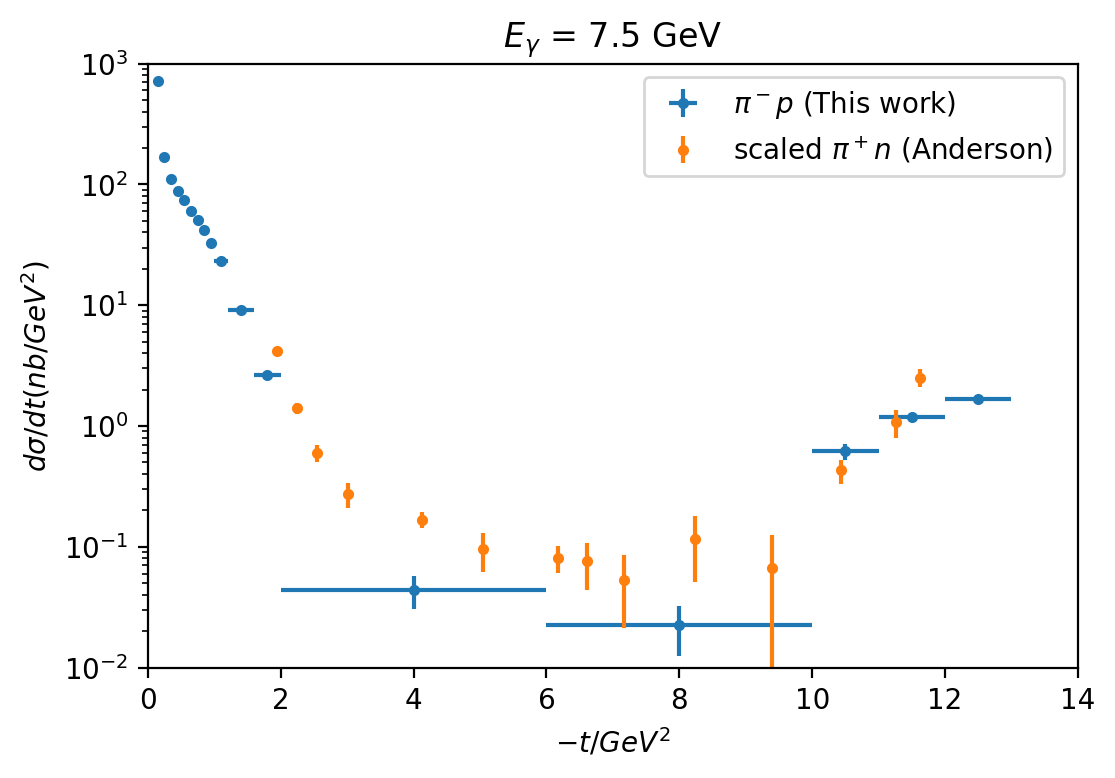

In [15]:
plt.rcParams['figure.dpi'] = 200
plt.xlabel("$-t/GeV^2$")
plt.ylabel("$d\sigma/dt (nb/GeV^2)$")
plt.yscale('log')
plt.title("$E_\gamma$ = 7.5 GeV")
plt.ylim(1e-2, 1e3)
plt.xlim(0,14)

points1 = []
points2 = []
for i in range(len(edges_minust[2])-1):
    points1.append((edges_minust[2][i]+edges_minust[2][i+1])/2)
    points2.append((edges_minust[2][i]-edges_minust[2][i+1])/2)

plt.errorbar(points1[:-1], cs[2][:-1], xerr = points2[:-1], yerr = cs_error[2][:-1], marker='.', fmt='o', label="$\pi^- p $ (This work)")
plt.yscale('log')

points_anderson = np.array([1.95, 2.24, 2.54, 3.02, 4.12, 5.04, 6.17, 6.61, 7.17, 8.23, 9.40, 10.43, 11.26, 11.63])
cs_anderson = np.array([3.45, 1.15, 0.481, 0.212, 0.121, 0.065, 0.050, 0.045, 0.03, 0.059, 0.03, 0.169, 0.374, 0.83])
cs_error_anderson = np.array([0.16, 0.12, 0.079, 0.051, 0.019, 0.023, 0.013, 0.019, 0.018, 0.033, 0.026, 0.038, 0.097, 0.14])
pion_ratio = piminus_to_piplus_ratio(np.ones(14)*Eg_to_SqrtS(7.5)**2, -points_anderson)
plt.errorbar(points_anderson, cs_anderson*pion_ratio, yerr=cs_error_anderson*pion_ratio, marker='.', fmt='o', label="scaled $\pi^+ n $ (Anderson)")

plt.legend()